# LSTM을 이용한 주가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Lambda

- Apple 주식 가격 예측

In [2]:
df = yf.download('AAPL', start='2010-01-01', end='2021-12-31', progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481929,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800


<Axes: xlabel='Date'>

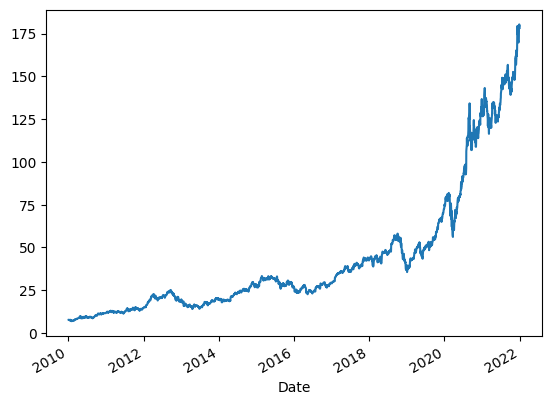

In [3]:
df.Close.plot()

LSTM layer로 하려고 하는 것은 지난 window-size 일(즉, t-window에서 t-1까지)의 역사적 가격을 사용하여 시간 t의 가격을 예측하는 것입니다. 정확한 가격이 아닌 추세를 파악하기 위해 노력할 것임을 명심하십시오.

In [4]:
df.shape

(3020, 6)

`len(df) - 100`일의 데이터로 모델을 학습시키고 다음 100일의 데이터로 테스트하는 방식으로 데이터를 분할합니다.
### train/test split

In [5]:
data_training = pd.DataFrame(df['Close'][:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70):])

data_training.shape, data_testing.shape

((2114, 1), (906, 1))

In [6]:
data_training.head()

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


- data normalization

In [7]:
scaler = MinMaxScaler()
data_training_array = scaler.fit_transform(data_training)
data_training_array.shape

(2114, 1)

In [8]:
data_training_array[:5]

array([[0.0192931 ],
       [0.01961817],
       [0.01662229],
       [0.01627964],
       [0.01750962]])

In [9]:
window = 100

In [10]:
X_train = []
y_train = []

for i in range(window, data_training.shape[0]):
    X_train.append(data_training_array[i-window: i])
    y_train.append(data_training_array[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2014, 100, 1), (2014,))

** train data가 잘 만들어 졌는지 확인하는 Tip** 

- hist의 각 element는 window개 timestep의 list입니다. 1씩 증가하기 때문에 X_train의 **두 번째 element의 마지막 항목**은 target의 **첫 번째 element**와 같아야 합니다. 또한 **마지막 element의 마지막 항목**은 target의 마지막 2번째 element와 같아야 합니다.

훈련 데이터의 i번째 원소의 마지막 값은 타깃 데이터의 (i-1)번째 값과 일치해야 합니다. 즉, X_train[i][-1] == y_train[i-1]이 성립해야 합니다. 이는 LSTM 모델이 'window' 개의 데이터를 바탕으로 그 다음 시점의 값을 예측하는 것이 목적이기 때문입니다.

또한, 훈련 데이터의 마지막 원소의 마지막 값은 타깃 데이터의 뒤에서 두 번째 값과 일치해야 합니다. 즉, X_train[-1][-1] == y_train[-2]가 성립해야 합니다. 이는 훈련 데이터와 타깃 데이터의 시퀀스가 올바르게 끝까지 유지되었음을 확인하는 검증입니다.

In [11]:
assert X_train[1][-1] == y_train[0], "시퀀스 시작 부분에서 데이터 불일치"
assert X_train[-1][-1] == y_train[-2], "시퀀스 끝 부분에서 데이터 불일치"

### model 생성 및 fitting

In [12]:
model = tf.keras.Sequential()
model.add(LSTM(units=16, input_shape=(window, 1)))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam

# Adam optimizer 인스턴스를 만들고 learning rate를 0.001로 설정합니다.
adam = Adam(learning_rate=0.001)

# 모델을 컴파일할 때 이 인스턴스를 optimizer 매개변수로 전달합니다.
model.compile(optimizer=adam, loss='mean_squared_error')

# 모델 학습을 시작합니다. 여기서는 훈련 데이터와 함께 epoch 수와 배치 크기를 지정합니다.
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
63/63 [==============================] - 2s 17ms/step - loss: 0.0661
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 6.0684e-04
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 5.2458e-04
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 5.1930e-04
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 5.0854e-04
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 5.0349e-04
Epoch 8/20
63/63 [==============================] - 1s 16ms/step - loss: 4.8689e-04
Epoch 9/20
63/63 [==============================] - 1s 16ms/step - loss: 4.7593e-04
Epoch 10/20
63/63 [==============================] - 1s 17ms/step - loss: 4.6212e-04
Epoch 11/20
63/63 [==============================] - 1s 17ms/step - loss: 4.4922e-04
Epoch 12/20
63/63 [==============================] - 1s 16ms/step - loss: 4.4151e-

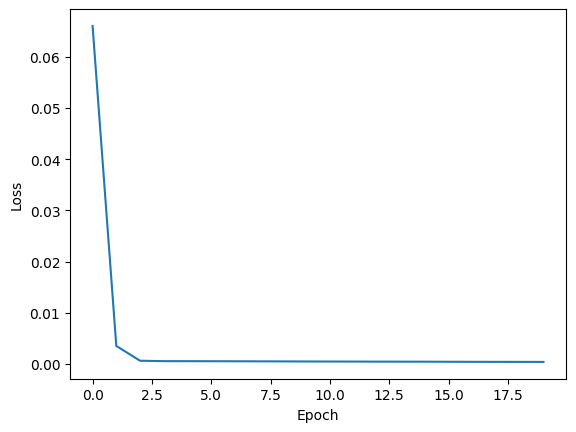

In [14]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylabel('Loss')
plt.show()

앞으로 100일 동안의 주가 추이를 예측해 보도록 하겠습니다. 우리의 목표는 실제 가격이 아니라 추세를 예측하는 것임을 기억하십시오. 첫번째 예측을 위해 과거 window 일 수 만큼의 data 가 필요하므로 training data의 마지막 window 갯수 만큼을 concatenate 합니다.

In [15]:
# Training 데이터의 마지막 100일을 가져옵니다.
past_window_days = data_training.tail(window)

# 이전 100일의 데이터와 테스트 데이터를 합칩니다.
final_df = pd.concat([past_window_days, data_testing])

# 최종 데이터프레임의 크기
final_df.shape

(1006, 1)

In [16]:
input_data = scaler.fit_transform(final_df)
input_data.shape

(1006, 1)

In [17]:
# 테스트 데이터를 만듭니다.
X_test = []
y_test = []

# 주어진 window 크기에 따라 X_test 및 y_test 데이터를 구성합니다.
for i in range(window, input_data.shape[0]):
    X_test.append(input_data[i-window:i])  # 이전 window 일동안의 데이터
    y_test.append(input_data[i, 0])  # 예측하고자 하는 날의 데이터
    
# 리스트를 넘파이 배열로 변환합니다.
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((906, 100, 1), (906,))

In [18]:
assert X_test[1][-1] == y_test[0], "시퀀스 시작 부분에서 데이터 불일치"
assert X_test[-1][-1] == y_test[-2], "시퀀스 끝 부분에서 데이터 불일치"

In [19]:
y_predicted = model.predict(X_test)
y_predicted.shape

29/29 [==============================] - 0s 5ms/step


(906, 1)

In [24]:
# scaler.scale_ 은 데이터 스케일링 변환에 사용된 스케일링 비율을 나타냅니다.
# scaler.data_min_ 은 각 특성(열)에서 관찰된 최소값을 나타냅니다.
scaler.scale_, scaler.data_min_

(array([0.00690691]), array([35.54750061]))

In [25]:
# 스케일링된 예측값을 원래의 스케일로 변환합니다.
# 먼저 예측값에 스케일링 비율(scaler.scale_)을 나누고, 이후 데이터의 최소값(scaler.data_min_)을 더함으로써 이루어집니다.
y_predicted = y_predicted / scaler.scale_ + scaler.data_min_

# 테스트 데이터셋의 타겟 변수도 원래의 스케일로 변환합니다.
# 마찬가지로 타겟 변수에 스케일링 비율을 나누고 최소값을 더하여 원래 스케일로 복원합니다.
y_test = y_test / scaler.scale_ + scaler.data_min_

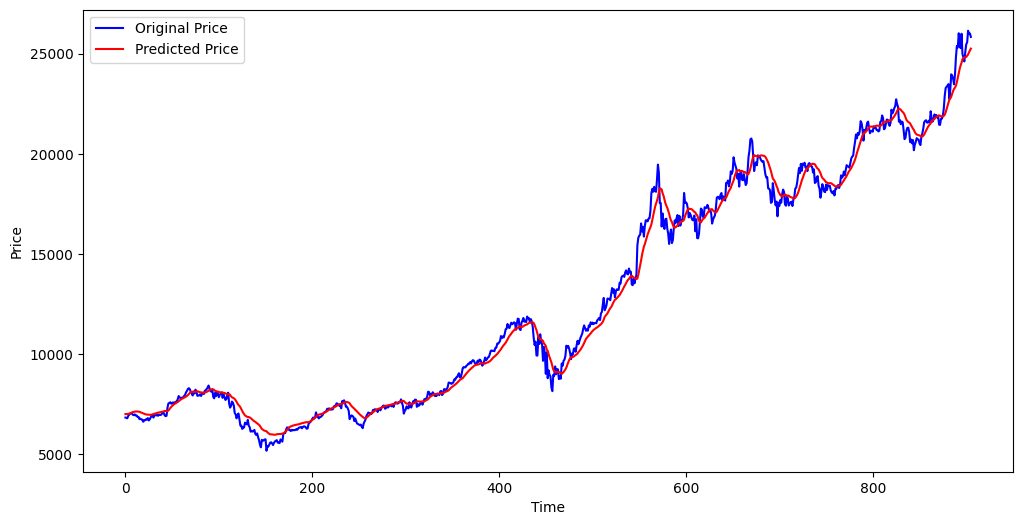

In [26]:
plt.figure(figsize=(12, 6))
# 원래 가격(실제 가격)을 파란색 선으로 표시
plt.plot(y_test, 'b', label='Original Price')
# 예측된 가격을 빨간색 선으로 표시
plt.plot(y_predicted, 'r', label='Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

최근 일자 부분만 확대하여 시각화

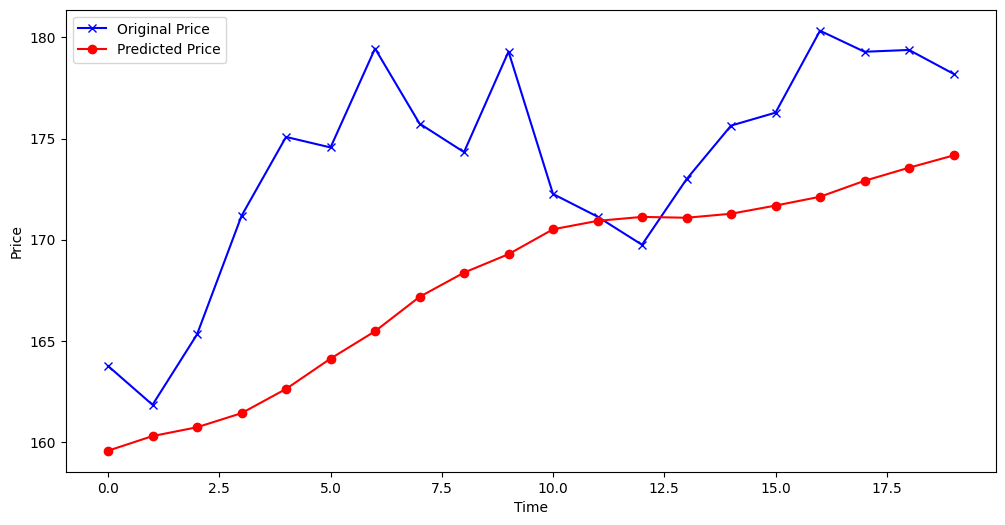

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[-20:], 'bx-', label='Original Price')
plt.plot(y_predicted[-20:], 'ro-', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 다양한 window_size tuning 을 하여 보다 정확한 예측 시도